# generate -> properties -> echem
- Generate microstructure from GAN
- calculate properties of electrolyte, particle, CBD phases
- simulate echem performance and extract metrics

c:\Users\pgasper\AppData\Local\anaconda3\envs\ustruct-to-echem\lib\site-packages\taufactor\taufactor.py:39: UserWarning: CUDA not available, defaulting device to cpu. To avoid this warning, explicitly set the device when initialising the solver with device=torch.device('cpu')
  warnings.warn(


0 0.7540707588195801 0.16334867477416992 0.4995323121547699
1 0.75762939453125 0.15777587890625 0.48787277936935425
2 0.7013444900512695 0.13493728637695312 0.4092724025249481


At t = 541.719 and h = 2.07597e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 250.81 and h = 1.57795e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 105.355 and h = 3.79748e-14, the corrector convergence failed repeatedly or with |h| = hmin.


3 0.7499322891235352 0.1766338348388672 0.552638590335846
4 0.5757713317871094 0.15429210662841797 0.21503794193267822
5 0.7335538864135742 0.1158447265625 0.4959309697151184
6 0.7066774368286133 0.11278772354125977 0.33069542050361633


At t = 548.78 and h = 1.32531e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 257.871 and h = 5.36322e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.417 and h = 7.30264e-14, the corrector convergence failed repeatedly or with |h| = hmin.


7 0.5610737800598145 0.21391630172729492 0.30146658420562744
8 0.8748221397399902 0.08174467086791992 0.7608309388160706


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


SolverError: Maximum number of decreased steps occurred at t=0.0 (final SolverError: 'Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.'). For a full solution try reducing dt_max (currently, dt_max=600) and/or reducing the size of the time steps or period of the experiment. Set `return_solution_if_failed_early=True` to return the solution object up to the point where failure occured.

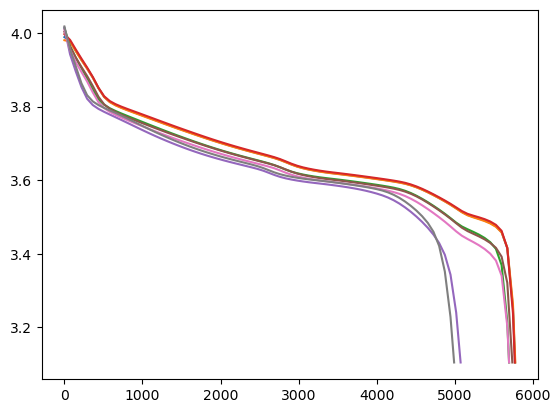

In [1]:
import numpy as np
import pybamm
import matplotlib.pyplot as plt
from utils.generate_new_volume import generate_new_volume
from utils.physical_properties import *

model_path = 'slicegan_model/four_phase_nmc'
phases = ['Pore','Crack','Particle','CBD']

# Diffusivity function to modify for Pybamm
def lico2_diffusivity(sto, T, coeff):
    """
    LiCo2 diffusivity as a function of stochiometry, in this case the
    diffusivity is taken to be a constant. The value is taken from Dualfoil [1].

    References
    ----------
    .. [1] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity
    """
    #D_ref = 1 * 10 ** (-13)
    D_ref = (coeff / 0.4) * 10 ** (-13) # 0.4 is a random number picked from some GAN runs
    E_D_s = 18550
    arrhenius = pybamm.exp(E_D_s / pybamm.pybamm.constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

capacities = np.zeros((10,1))
for i in range(len(capacities)):
    vol = generate_new_volume(model_path)
    '''
    Properties to modify:
    - Positive electrode porosity
    - Positive electrode active material volume fraction
    Things to work on later:
    - inputting Deff into positive electrode diffusivity (need to modify function in parameters)
    - inputting particle size (current volume is too small to have 'particles')
        - use surface area to reverse calculate particle size? particle size controls surface area in pybamm (sphere = 3/(r*(1-vf_pore)))
    '''
    # Set all cracks and pores equal for porosity
    vol[vol==1] = 0
    vf_particle = volume_fraction(vol, phase_class=2)
    vf_pore     = volume_fraction(vol, phase_class=0)
    # pybamm can fail at extreme values
    if vf_particle > 0.85:
        vf_particle = 0.85
    if vf_pore < 0.09:
        vf_pore = 0.09

    # Diffusivity and tortuosity
    # Set all phases to 0 except particle for taufactor
    vol[vol==3] = 0
    vol[vol==2] = 1
    homogenized_properties = compute_tau_and_D_eff(vol, verbose=False)
    D_eff = homogenized_properties['D_eff'].item()

    ####print(i, vf_particle, vf_pore, D_eff)

    # PyBaMM model
    model = pybamm.lithium_ion.DFN()
    # Default parameter set
    params = pybamm.ParameterValues("Marquis2019")
    # Modify parameters
    params['Positive electrode porosity'] = vf_pore
    params['Positive electrode active material volume fraction'] = vf_particle
    params['Positive electrode diffusivity [m2.s-1]'] = lambda sto, T: lico2_diffusivity(sto, T, D_eff)
    # Run the simulation
    sim = pybamm.Simulation(model,parameter_values=params)
    sim.solve([0, 7200],initial_soc=1)
    sol = sim.solution
    # Save the discharge capacity
    capacities[i] = sol['Discharge capacity [A.h]'].entries[-1]

    # Plot to see if the simulations are any different
    plt.plot(sol['Time [s]'].entries, sol['Voltage [V]'].entries)

plt.show()


[[0.680616  ]
 [0.680616  ]
 [0.53449797]
 [0.680616  ]
 [0.680616  ]
 [0.680616  ]
 [0.680616  ]
 [0.65226772]
 [0.680616  ]
 [0.680616  ]]


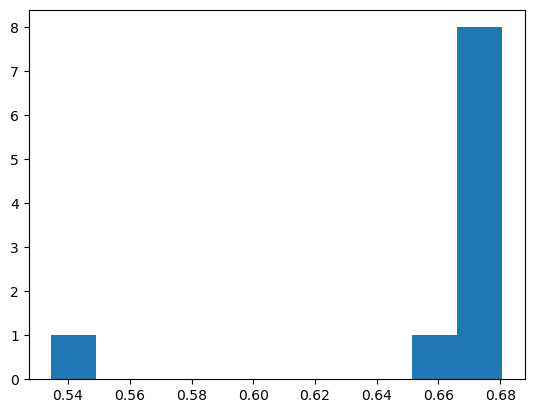

In [ ]:
print(capacities)
plt.hist(capacities)
plt.show()

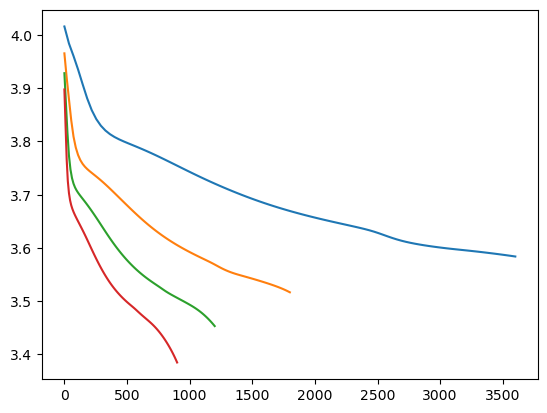

In [ ]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

model = pybamm.lithium_ion.DFN()
# Default parameter set
params = pybamm.ParameterValues("Marquis2019")
# Modify parameters
current = params['Current function [A]']
for i in np.arange(4):
    params['Current function [A]'] = (i+1) * current
    sim = pybamm.Simulation(model,parameter_values=params)
    sim.solve([0, 3600/(i+1)],initial_soc=1)
    sol = sim.solution
    plt.plot(sol['Time [s]'].entries, sol['Voltage [V]'].entries)
